In [47]:
from tempfile import tempdir
import SimpleITK as sitk
import numpy as np
import numpy.ma as ma
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
#import seaborn as sns
import pandas as pd
from datetime import datetime, date

In [48]:
patID = "251842"
patID_l = "251842"

scan_info = pd.read_csv('D:/data/Aaron/ProstateMRL/Data/MRLPacks/ScanInfo/' + patID_l + '.csv')
scan_info = scan_info.dropna()

output = 'D:/data/Aaron/ProstateMRL/Data/Extraction/MRLPacks/RawPlotsWM/' 



In [49]:
new_dt = {"ScanDate":[], "ScanTime":[]}#, "DaysFromFrac1":[], "MinsFromScan1":[]}
temp = pd.DataFrame()

for index, row in scan_info.iterrows():
    date = str(row["ScanDate"])
    year, month, day = date[0:4], date[4:6], date[6:]
    #print(year, month, day)
    new_date = pd.to_datetime(str(year + "-" + month + "-" + day))
    new_dt["ScanDate"] = new_date
    
    
    time = str(row["ScanTime"])
    hour, min, sec = time[0:2], time[2:4], time[4:6]
    new_time = pd.to_datetime(str(hour + ":" + min + ":" + sec))
    new_dt["ScanTime"] = new_time

    temp = temp.append(new_dt, ignore_index=True)

temp["ScanTime"] = temp["ScanTime"].dt.time

141838.00400000002
14 18 38
143442.392
14 34 42
144242.809
14 42 42
142339.046
14 23 39
143848.551
14 38 48
144521.72199999998
14 45 21
140848.77
14 08 48
142302.063
14 23 02
143025.797
14 30 25
140058.94
14 00 58
141615.721
14 16 15
142310.283
14 23 10
143228.478
14 32 28
144800.18300000002
14 48 00
145546.72
14 55 46


In [50]:
scan_info = scan_info.drop(["ScanTime", "ScanDate"], axis=1)
scan_info = pd.concat([scan_info,temp],axis=1)

In [51]:
diff = {}
contours = scan_info.MRContour.unique()
results = pd.DataFrame()

for i in contours:
    temp = scan_info.loc[scan_info["MRContour"].isin([i])]

    for index, row in temp.iterrows():
        diff["PatID"] = row["patID"]
        diff["MRContour"] = i
        diff["Fraction"] = int(row["Fraction"])
        diff["Scan"] = int(row["Scan"])

        if row["Scan"] == 1:
            #print("hello")
            Day1, Time1 = row["ScanDate"], row["ScanTime"]
            hour1, mins1 = Time1.hour, Time1.minute
            pros1, shpros1, glute1, psoas1 = row["MeanProstate"], row["MeanShrunkProstate"], row["MeanGlute"], row["MeanPsoas"]
            diff["TimeChange"] = 0
            diff["Prostate"], diff["ShrunkProstate"], diff["Glute"], diff["Psoas"] = row["MeanProstate"], row["MeanShrunkProstate"], row["MeanGlute"], row["MeanPsoas"]
            diff["d-Prostate"], diff["d-ShrunkProstate"], diff["d-Glute"], diff["d-Psoas"] = 0,0,0,0

        else:
            Time2 = row["ScanTime"]
            hour2, mins2 = Time2.hour, Time2.minute
            hour_d = hour2-hour1
            min_d = mins2 - mins1
            if min_d < 0:
                total_mins = 60 + min_d
            else:
                total_mins = hour_d * 60 + min_d

            diff["TimeChange"] = total_mins
            diff["Prostate"], diff["ShrunkProstate"], diff["Glute"], diff["Psoas"] = row["MeanProstate"], row["MeanShrunkProstate"], row["MeanGlute"], row["MeanPsoas"]
            diff["d-Prostate"] = row["MeanProstate"] - pros1
            diff["d-ShrunkProstate"] = row["MeanShrunkProstate"] - shpros1
            diff["d-Glute"] = row["MeanGlute"] - glute1
            diff["d-Psoas"] = row["MeanPsoas"] - psoas1

        results = results.append(diff, ignore_index=True)

results = results[["PatID", "Fraction", "MRContour", "Scan", "TimeChange", "Prostate", "d-Prostate","ShrunkProstate","d-ShrunkProstate","Glute", "d-Glute", "Psoas", "d-Psoas"]]
results = results.astype({"Fraction": int, "Scan": int})
results.to_csv("D:\data\Aaron\ProstateMRL\Data\MRLPacks\MeanValues\\" + patID + ".csv")

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

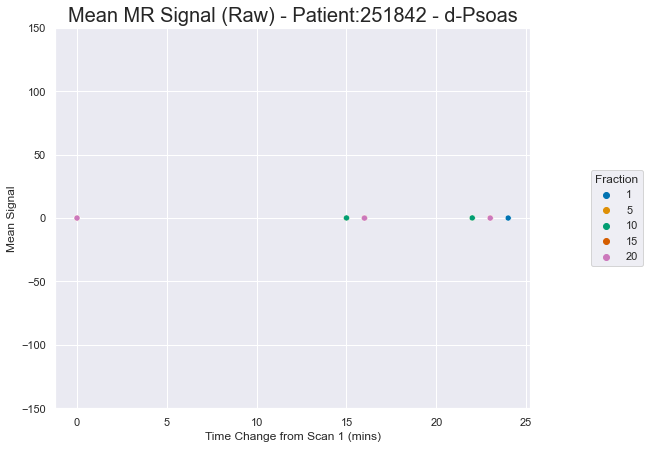

In [52]:
fractions = results.Fraction.unique()
rgb_vals = sns.color_palette("colorblind", len(fractions))
colourmap = dict(zip(fractions, rgb_vals))

fig = plt.figure(figsize=(10,7))
sns.set_theme(style='darkgrid')
plt.xlabel("Time Change from Scan 1 (mins)")   
plt.ylabel("Mean Signal Change")
plt.ylim(-300,300)

region = ["Prostate", "ShrunkProstate", "Glute", "Psoas", "d-Prostate", "d-ShrunkProstate", "d-Glute", "d-Psoas"]

for i in range(8):
    plt.clf()
    fig = plt.figure(figsize=(10,7))
    sns.set_theme(style='darkgrid')
    plt.xlabel("Time Change from Scan 1 (mins)")   
    plt.ylabel("Mean Signal")
    if i < 2:
        plt.ylim(0,300)
    elif 1 < i < 4: 
        plt.ylim(0,150)
    elif 3 < i < 6:
        plt.ylim(-300,300)
    elif 5 < i:
        plt.ylim(-150,150)
    plt.title("Mean MR Signal (Raw) - Patient:" + patID + " - " + region[i], fontsize=20)
    plot = sns.scatterplot(data=results, x='TimeChange', y=region[i], hue='Fraction',palette=colourmap)
    #plot_l = sns.lineplot(data=results, x='TimeChange', y=region[i], hue='Fraction',palette=colourmap)
    box = plot.get_position()
    plot.set_position([box.x0, box.y0, box.width * 0.85, box.height]) # resize position

    # Put a legend to the right side
    plot.legend(loc='center right', bbox_to_anchor=(1.25, 0.5), ncol=1, title="Fraction")
    plt.savefig("D:\data\Aaron\ProstateMRL\Data\MRLPacks\RawPlotsWM\\" + patID + "_" + region[i] + ".png", dpi=300)
    